In [30]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
# import spicy
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier
from streamz import Stream
from newsapi.newsapi_client import NewsApiClient
from datetime import date, datetime, timedelta
import os
import time
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import panel as pn
pn.extension('katex')
from panel.interact import interact
from panel import widgets
from ipywidgets import widgets
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import hvplot.pandas

In [2]:
# Get current date and the date one month ago

num_of_weeks = 52 #in weeks

current_date = date.today()
past_date = date.today() - timedelta(weeks=num_of_weeks)

In [90]:
# Create a general function that will allow the user to input their stocks and the code will populate the dataframe with the stock info

user_input = 'MSFT'
def share_price(user_input):
  url='http://download.macrotrends.net/assets/php/stock_data_export.php?t='+ user_input
  stock_price=pd.read_csv(url,skiprows=14)
  df=pd.DataFrame(stock_price)
  return df

stock_prices = share_price(user_input).copy()
stock_prices = pd.DataFrame(stock_prices)
stock_prices.columns = ['Date','Open','High','Low','Close','Volume']
stock_prices

Date      Open      High       Low     Close      Volume
0     1986-03-13    0.0885    0.1016    0.0885    0.0972  1031788800
1     1986-03-14    0.0972    0.1024    0.0972    0.1007   308160000
2     1986-03-17    0.1007    0.1033    0.1007    0.1024   133171200
3     1986-03-18    0.1024    0.1033    0.0990    0.0998    67766400
4     1986-03-19    0.0998    0.1007    0.0972    0.0981    47894400
...          ...       ...       ...       ...       ...         ...
8592  2020-04-15  171.2000  173.5700  169.2400  171.8800    40940833
8593  2020-04-16  174.3000  177.2800  172.9000  177.0400    50479610
8594  2020-04-17  179.5000  180.0000  175.8700  178.6000    52765625
8595  2020-04-20  176.6300  178.7500  174.9900  175.0600    36108430
8596  2020-04-21  173.5000  173.6699  166.1102  167.8200    56203749

[8597 rows x 6 columns]

In [91]:
#Creating a function to do a simple 90 day simple moving average on the volume of the shares traded
def ma_volume_90(stock_prices):
    window = 5
    days = 90
    sma_days = stock_prices['Volume'].rolling(window).mean()
    sma_days = pd.DataFrame(sma_days)
    sma_days.columns = ['90 Day SMA']
    sma_days = sma_days['90 Day SMA'].rolling(days).mean()
    sma_days_df = pd.DataFrame(sma_days)
    sma_days_df = pd.concat([stock_prices,sma_days_df],axis="columns",join="inner")
    return sma_days_df

sma_days_df_90 = ma_volume_90(stock_prices).copy()
sma_days_df_90




Date      Open      High       Low     Close      Volume  \
0     1986-03-13    0.0885    0.1016    0.0885    0.0972  1031788800   
1     1986-03-14    0.0972    0.1024    0.0972    0.1007   308160000   
2     1986-03-17    0.1007    0.1033    0.1007    0.1024   133171200   
3     1986-03-18    0.1024    0.1033    0.0990    0.0998    67766400   
4     1986-03-19    0.0998    0.1007    0.0972    0.0981    47894400   
...          ...       ...       ...       ...       ...         ...   
8592  2020-04-15  171.2000  173.5700  169.2400  171.8800    40940833   
8593  2020-04-16  174.3000  177.2800  172.9000  177.0400    50479610   
8594  2020-04-17  179.5000  180.0000  175.8700  178.6000    52765625   
8595  2020-04-20  176.6300  178.7500  174.9900  175.0600    36108430   
8596  2020-04-21  173.5000  173.6699  166.1102  167.8200    56203749   

        90 Day SMA  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
8592  4.323035e+07  
8593  4.353393e+07  
8594  4.383266e+07  
8595  4.414560e+07  
8596  4.448529e+07  

[8597 rows x 7 columns]

In [92]:
#Creating a function to do a simple 30 day simple moving average on the volume of the shares traded
def ma_volume_30(stock_prices):
    window = 5
    days = 30
    sma_days = stock_prices['Volume'].rolling(window).mean()
    sma_days = pd.DataFrame(sma_days)
    sma_days.columns = ['30 Day SMA']
    sma_days = sma_days['30 Day SMA'].rolling(days).mean()
    sma_days_df = pd.DataFrame(sma_days)
    sma_days_df = pd.concat([stock_prices,sma_days_df],axis="columns",join="inner")
    return sma_days_df

sma_days_df_30 = ma_volume_30(stock_prices).copy()
sma_days_df_30

Date      Open      High       Low     Close      Volume  \
0     1986-03-13    0.0885    0.1016    0.0885    0.0972  1031788800   
1     1986-03-14    0.0972    0.1024    0.0972    0.1007   308160000   
2     1986-03-17    0.1007    0.1033    0.1007    0.1024   133171200   
3     1986-03-18    0.1024    0.1033    0.0990    0.0998    67766400   
4     1986-03-19    0.0998    0.1007    0.0972    0.0981    47894400   
...          ...       ...       ...       ...       ...         ...   
8592  2020-04-15  171.2000  173.5700  169.2400  171.8800    40940833   
8593  2020-04-16  174.3000  177.2800  172.9000  177.0400    50479610   
8594  2020-04-17  179.5000  180.0000  175.8700  178.6000    52765625   
8595  2020-04-20  176.6300  178.7500  174.9900  175.0600    36108430   
8596  2020-04-21  173.5000  173.6699  166.1102  167.8200    56203749   

        30 Day SMA  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
8592  6.811606e+07  
8593  6.714237e+07  
8594  6.648605e+07  
8595  6.595277e+07  
8596  6.544951e+07  

[8597 rows x 7 columns]

In [93]:
#Create a function to calculate the Maximum rolling volume using the exponential moving average 

def ema_volume(stock_prices):
  window = 5
  weights = np.exp(np.linspace(-1.,0.,window))
  weights /= weights.sum()
  max_volume=np.convolve(stock_prices['Volume'],weights,'valid')[:len(stock_prices)]
  max_volume[:window]=max_volume[window]
  max_volume = pd.DataFrame(max_volume)
  max_volume.columns = ['max_volume']
  max_volume = max_volume['max_volume'].rolling(180).max()
  max_volume_df = pd.concat([stock_prices, max_volume], axis="columns", join="inner")
  return max_volume_df

max_volume_df = ema_volume(stock_prices).copy()

max_volume_df

Date      Open      High       Low     Close      Volume  \
0     1986-03-13    0.0885    0.1016    0.0885    0.0972  1031788800   
1     1986-03-14    0.0972    0.1024    0.0972    0.1007   308160000   
2     1986-03-17    0.1007    0.1033    0.1007    0.1024   133171200   
3     1986-03-18    0.1024    0.1033    0.0990    0.0998    67766400   
4     1986-03-19    0.0998    0.1007    0.0972    0.0981    47894400   
...          ...       ...       ...       ...       ...         ...   
8588  2020-04-08  165.6700  166.6700  163.5000  165.1300    48107016   
8589  2020-04-09  166.3600  167.3700  163.3300  165.1400    50516088   
8590  2020-04-13  164.3500  165.5700  162.3000  165.5100    41905264   
8591  2020-04-14  169.0000  173.7500  168.0000  173.7000    52874338   
8592  2020-04-15  171.2000  173.5700  169.2400  171.8800    40940833   

        max_volume  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
8588  8.879835e+07  
8589  8.879835e+07  
8590  8.879835e+07  
8591  8.879835e+07  
8592  8.879835e+07  

[8593 rows x 7 columns]

In [94]:
#Create a function to calculate the Minimum rolling volume using the exponential moving average 
def ema_volume_2(stock_prices):
  window = 5
  weights = np.exp(np.linspace(-1.,0.,window))
  weights /= weights.sum()
  min_volume=np.convolve(stock_prices['Volume'],weights,'valid')[:len(stock_prices)]
  min_volume[:window]=min_volume[window]
  min_volume = pd.DataFrame(min_volume)
  min_volume.columns = ['min_volume']
  min_volume = min_volume['min_volume'].rolling(180).min()
  min_volume_df = pd.concat([stock_prices, min_volume], axis="columns", join="inner")
  return min_volume_df

min_volume_df = ema_volume_2(stock_prices).copy()
min_volume_df

Date      Open      High       Low     Close      Volume  \
0     1986-03-13    0.0885    0.1016    0.0885    0.0972  1031788800   
1     1986-03-14    0.0972    0.1024    0.0972    0.1007   308160000   
2     1986-03-17    0.1007    0.1033    0.1007    0.1024   133171200   
3     1986-03-18    0.1024    0.1033    0.0990    0.0998    67766400   
4     1986-03-19    0.0998    0.1007    0.0972    0.0981    47894400   
...          ...       ...       ...       ...       ...         ...   
8588  2020-04-08  165.6700  166.6700  163.5000  165.1300    48107016   
8589  2020-04-09  166.3600  167.3700  163.3300  165.1400    50516088   
8590  2020-04-13  164.3500  165.5700  162.3000  165.5100    41905264   
8591  2020-04-14  169.0000  173.7500  168.0000  173.7000    52874338   
8592  2020-04-15  171.2000  173.5700  169.2400  171.8800    40940833   

        min_volume  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
8588  1.425001e+07  
8589  1.425001e+07  
8590  1.425001e+07  
8591  1.425001e+07  
8592  1.425001e+07  

[8593 rows x 7 columns]

In [95]:
volume_df = pd.concat([stock_prices,min_volume_df['min_volume'],max_volume_df['max_volume'],sma_days_df_90['90 Day SMA'],sma_days_df_30['30 Day SMA']],axis="columns",join="inner")
volume_df.set_index(['Date'])

Open      High       Low     Close      Volume    min_volume  \
Date                                                                           
1986-03-13    0.0885    0.1016    0.0885    0.0972  1031788800           NaN   
1986-03-14    0.0972    0.1024    0.0972    0.1007   308160000           NaN   
1986-03-17    0.1007    0.1033    0.1007    0.1024   133171200           NaN   
1986-03-18    0.1024    0.1033    0.0990    0.0998    67766400           NaN   
1986-03-19    0.0998    0.1007    0.0972    0.0981    47894400           NaN   
...              ...       ...       ...       ...         ...           ...   
2020-04-08  165.6700  166.6700  163.5000  165.1300    48107016  1.425001e+07   
2020-04-09  166.3600  167.3700  163.3300  165.1400    50516088  1.425001e+07   
2020-04-13  164.3500  165.5700  162.3000  165.5100    41905264  1.425001e+07   
2020-04-14  169.0000  173.7500  168.0000  173.7000    52874338  1.425001e+07   
2020-04-15  171.2000  173.5700  169.2400  171.8800    40940833  1.425001e+07   

              max_volume    90 Day SMA    30 Day SMA  
Date                                                  
1986-03-13           NaN           NaN           NaN  
1986-03-14           NaN           NaN           NaN  
1986-03-17           NaN           NaN           NaN  
1986-03-18           NaN           NaN           NaN  
1986-03-19           NaN           NaN           NaN  
...                  ...           ...           ...  
2020-04-08  8.879835e+07  4.182128e+07  7.120958e+07  
2020-04-09  8.879835e+07  4.221772e+07  7.077193e+07  
2020-04-13  8.879835e+07  4.258978e+07  7.001554e+07  
2020-04-14  8.879835e+07  4.292609e+07  6.914940e+07  
2020-04-15  8.879835e+07  4.323035e+07  6.811606e+07  

[8593 rows x 9 columns]

In [96]:
# Volume Trade Signal

def volume_trade_strategy(volume_df): 
    if volume_df['Volume'] > volume_df['max_volume']:
        v_signal = 1
    elif volume_df['Volume'] < volume_df['min_volume']:  
        v_signal = -1
    else:
        v_signal = 0
    
    return v_signal

volume_df['v_signal'] = volume_df.apply(volume_trade_strategy, axis=1).copy()
volume_df

Date      Open      High       Low     Close      Volume  \
0     1986-03-13    0.0885    0.1016    0.0885    0.0972  1031788800   
1     1986-03-14    0.0972    0.1024    0.0972    0.1007   308160000   
2     1986-03-17    0.1007    0.1033    0.1007    0.1024   133171200   
3     1986-03-18    0.1024    0.1033    0.0990    0.0998    67766400   
4     1986-03-19    0.0998    0.1007    0.0972    0.0981    47894400   
...          ...       ...       ...       ...       ...         ...   
8588  2020-04-08  165.6700  166.6700  163.5000  165.1300    48107016   
8589  2020-04-09  166.3600  167.3700  163.3300  165.1400    50516088   
8590  2020-04-13  164.3500  165.5700  162.3000  165.5100    41905264   
8591  2020-04-14  169.0000  173.7500  168.0000  173.7000    52874338   
8592  2020-04-15  171.2000  173.5700  169.2400  171.8800    40940833   

        min_volume    max_volume    90 Day SMA    30 Day SMA  v_signal  
0              NaN           NaN           NaN           NaN         0  
1              NaN           NaN           NaN           NaN         0  
2              NaN           NaN           NaN           NaN         0  
3              NaN           NaN           NaN           NaN         0  
4              NaN           NaN           NaN           NaN         0  
...            ...           ...           ...           ...       ...  
8588  1.425001e+07  8.879835e+07  4.182128e+07  7.120958e+07         0  
8589  1.425001e+07  8.879835e+07  4.221772e+07  7.077193e+07         0  
8590  1.425001e+07  8.879835e+07  4.258978e+07  7.001554e+07         0  
8591  1.425001e+07  8.879835e+07  4.292609e+07  6.914940e+07         0  
8592  1.425001e+07  8.879835e+07  4.323035e+07  6.811606e+07         0  

[8593 rows x 11 columns]

In [97]:
#Share Price Signal Function

def bollinger_band_signal(stock_prices):
    
    bollinger_window = 20
    sp_bollinger_mid_band = stock_prices['Close'].rolling(window=bollinger_window).mean()
    sp_bollinger_std = stock_prices['Close'].rolling(window=20).std()
    sp_bollinger_upper_band  = sp_bollinger_mid_band + (sp_bollinger_std * 2)
    sp_bollinger_lower_band  = sp_bollinger_mid_band - (sp_bollinger_std * 2)
    sp_bollinger_long = np.where(stock_prices['Close'] < sp_bollinger_lower_band, 1.0, 0.0)
    sp_bollinger_short = np.where(stock_prices['Close'] > sp_bollinger_upper_band, -1.0, 0.0)
    stock_prices['sp_signal'] = sp_bollinger_long + sp_bollinger_short
    
    return stock_prices
  
bollinger_df = bollinger_band_signal(stock_prices).copy()
bollinger_band_signal(stock_prices)



Date      Open      High       Low     Close      Volume  \
0     1986-03-13    0.0885    0.1016    0.0885    0.0972  1031788800   
1     1986-03-14    0.0972    0.1024    0.0972    0.1007   308160000   
2     1986-03-17    0.1007    0.1033    0.1007    0.1024   133171200   
3     1986-03-18    0.1024    0.1033    0.0990    0.0998    67766400   
4     1986-03-19    0.0998    0.1007    0.0972    0.0981    47894400   
...          ...       ...       ...       ...       ...         ...   
8592  2020-04-15  171.2000  173.5700  169.2400  171.8800    40940833   
8593  2020-04-16  174.3000  177.2800  172.9000  177.0400    50479610   
8594  2020-04-17  179.5000  180.0000  175.8700  178.6000    52765625   
8595  2020-04-20  176.6300  178.7500  174.9900  175.0600    36108430   
8596  2020-04-21  173.5000  173.6699  166.1102  167.8200    56203749   

      sp_signal  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
...         ...  
8592        0.0  
8593        0.0  
8594        0.0  
8595        0.0  
8596        0.0  

[8597 rows x 7 columns]

In [98]:
signals_df = pd.concat([volume_df['Date'],bollinger_df['sp_signal'],volume_df['v_signal']], axis = 'columns', join = 'inner')
signals_df

Date  sp_signal  v_signal
0     1986-03-13        0.0         0
1     1986-03-14        0.0         0
2     1986-03-17        0.0         0
3     1986-03-18        0.0         0
4     1986-03-19        0.0         0
...          ...        ...       ...
8588  2020-04-08        0.0         0
8589  2020-04-09        0.0         0
8590  2020-04-13        0.0         0
8591  2020-04-14        0.0         0
8592  2020-04-15        0.0         0

[8593 rows x 3 columns]

In [99]:
# Set up Panel Plotly extension
pn.extension()

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Close')

Text(0, 0.5, 'Volume')

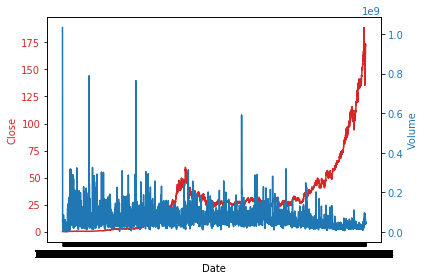

In [100]:
import matplotlib.pyplot as plt



fig, ax1 = plt.subplots()
title = user_input
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close', color=color)
ax1.plot(volume_df['Date'], volume_df['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Volume', color=color)  # we already handled the x-label with ax1
ax2.plot(volume_df['Date'], volume_df['Volume'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

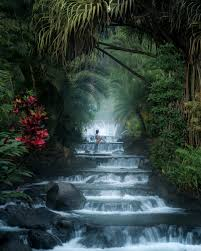

:NdLayout   [Variable]
   :Curve   [Date]   (value)

In [58]:
#Import necessary libraries
from holoviews import dim, opts
from holoviews.plotting.bokeh.styles import (line_properties, fill_properties, text_properties)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path


#Graohs for first tab

overview_graph = volume_df.hvplot.line(x='Date', y=['Close','Volume','90 Day SMA'],value_label='Closing Price') 


    
#Graphs for Second Tab
volume_graph = volume_df.hvplot(x='Date', y=['Volume',  '90 Day SMA', '30 Day SMA', 'min_volume','max_volume'], 
                width=350, height=300, subplots=True, shared_axes=False).cols(2)



#Graphs for Third Tab

analysis_df = consolidated_df.hvplot.line(x='Date',y=['Close','sp_signal','v_signal'])
bollinger_signals = bollinger_df.hvplot(x='Date',y=['sp_signal'],value_label='Buy/Sell Signals')


jpegPath = Path("costa_rica_image.jpeg")
# Display Costa Rica JPEG
with open(jpegPath,'rb') as f:
    image = display.Image(data=f.read(), format='png', width = 400, height = 200)
image
volume_graph


In [20]:

import dash
import dash_html_components as html
import dash_core_components as dcc

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
app.layout = html.Div([
    html.Div(dcc.Input(id='input-box', type='text')),
    html.Button('Submit', id='button'),
    html.Div(id='output-container-button',
             children='Enter a ticker from your portfolio and press submit')
])


@app.callback(
    dash.dependencies.Output('output-container-button', 'children'),
    [dash.dependencies.Input('button', 'n_clicks')],
    [dash.dependencies.State('input-box', 'value')])

def update_output(n_clicks, value):
    return 'The input value was "{}" and the button has been clicked {} times'.format(
        value,
        n_clicks
    )


if __name__ == '__main__':
    app.run_server(debug=True)

Running on http://127.0.0.1:8050/
Debugger PIN: 874-243-103
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


SystemExit: 1

In [24]:
# Create a function to accept input and return a Dataframe

def share_price(user_input):
  url='http://download.macrotrends.net/assets/php/stock_data_export.php?t='+ user_input
  stock_price=pd.read_csv(url,skiprows=14)
  df=pd.DataFrame(stock_price)
  return df

# Build_dashboard

def build_dashboard(volume_df):
    #Intro Graph 
    overview_graph = volume_df.hvplot.line(x='Date', y=['Close','Volume','30 Day SMA'],value_label='Closing Price')
    volume_graph = volume_df.hvplot.line(x='Date',y=['90 Day SMA', '30 Day SMA','min_volume','max_volume','Volume'])
    #Create summary news table on the dashboard 
    #media_table = 
    
    #Create dropdown menu to choose 

    
    return dashboard

# Create function for a panel to populate twitter and news feed on the right of the graph

# Create function for signals to be graphed

# Dropdown Menu to select display
signal_graph = bollinger_df.hvplot(x='Date',y=['sp_signal'],value_label='Buy/Sell Signals')

In [107]:
#Dashboard Title
title = pn.pane.Markdown(
    """
# PuraVida
<img src="https://images.squarespace-cdn.com/content/v1/572164baf8508222d12dcd6e/1513565082275-S0USBDTQDFKXSAVAGV9X/ke17ZwdGBToddI8pDm48kJ5a22CA6cnGPk0MICWiq4h7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1UTyHg1UW0Z9qDDvIOCyLEa7WhUyB18-tTFCiT-EhnOhpy4esdQB3BRl8sZrbGldWOw/Chasing+Waterfalls+In+Costa+Rica" alt="Past Performance is not indicative of future performance" width="150" height="100" />

######Past Performance is not indicative of future performance

""",
    width=800,
)

#Create Panel Column Tabs
tabs = pn.Tabs(("Welcome", "This dashboard was built to help you get direction to navigate through the stock market jungle. You will be able to input your stock portfolio and receive recommendations on your stock. This model was built on the basis of key driving factors in the market. Past Performance is not indicative of future performance"),
("Overview", fig),
("Volume Analysis", volume_graph),
("Trigger Point Analysis",bollinger_signals)
)


panel = pn.Column(pn.Row(title), tabs, width=900)

Column(width=900)
    [0] Row
        [0] Markdown(str, width=800)
    [1] Tabs
        [0] Markdown(str, name='Welcome')
        [1] Matplotlib(Figure, name='Overview')
        [2] HoloViews(NdLayout, name='Volume Analysis')
        [3] HoloViews(Curve, name='Trigger Point Analysis')
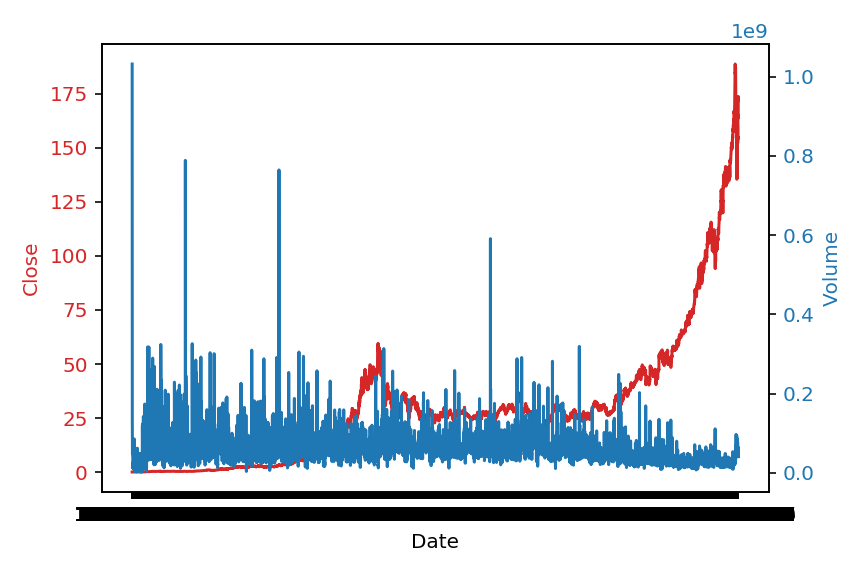

In [108]:
panel.servable()

In [29]:
def initialize():
    """Initialize the dashboard, data storage, and account balances."""
    # @TODO: We will complete this later!
    pass



# Build input function
from IPython.display import display
text = widgets.Text()
display(text)

def user_input(sender):
    print(text.value)
    
text.on_submit(user_input)

button = widgets.Button(description="Please input your stock ticker")
display(button)

def on_button_clicked(b):
    print("Ticker as inputted")

button.on_click(button)


def stock_price_graph(user_input):
    return price_graph.hvplot.line(x='Date',y='Close')

volume_graph = stock_prices['Volume']

def stock_volume_graph(stock_prices):
    return volume_graph.hvplot.bar(x='Date',y='Volume')

def main():
    """Main Event Loop."""
    volume_df = user_input()
    signals_df = generate_signals(data_df)
    tested_signals_df = execute_backtest(signals_df)
    portfolio_evaluation_df = evaluate_metrics(tested_signals_df)
    dashboard = build_dashboard(tested_signals_df, portfolio_evaluation_df)
    dashboard.servable()
    return


Text(value='')

Button(description='Please input your stock ticker', style=ButtonStyle())